# Colour Correction using Splines

### Define constants

In [95]:
%load_ext autoreload
%autoreload 2
import colour
from data import load_dataset_sfu, load_dataset_csv, load_msds_canon, load_msds_sigma, load_msds_nikon, load_illuminant_cmfs
import numpy as np

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

SFU_FILE_PATH = 'reflect_db.reflect'
CAVE_FOSTER2004_PATH = 'cave_foster2004.csv'
FOSTER_50_PATH = 'foster50.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
sfu_dataset = load_dataset_sfu(SFU_FILE_PATH)
cave_foster2004_dataset = load_dataset_csv(CAVE_FOSTER2004_PATH)
foster_50_dataset = load_dataset_csv(FOSTER_50_PATH)

TRAIN = cave_foster2004_dataset
TEST = foster_50_dataset
VALIDATION = sfu_dataset

### Spectral sensitivities of various cameras

In [97]:
msds_canon, illuminant_canon = load_msds_canon()
msds_nikon, illuminant_nikon = load_msds_nikon()
msds_sigma, illuminant_sigma = load_msds_sigma()

MSDS_TRAIN = msds_canon
SDS_TRAIN = illuminant_canon

### Computing Observer Responses
We can easily change the order of test and train sets here

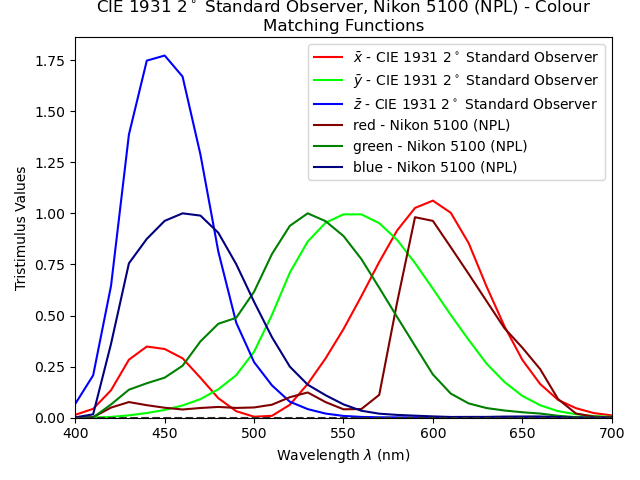

In [98]:
illuminant, cmfs = load_illuminant_cmfs()
colour.plotting.plot_multi_cmfs([msds_nikon, cmfs])
response_trainset_xyz = colour.characterisation.training_data_sds_to_XYZ(TRAIN, cmfs, illuminant)
response_testset_xyz = colour.characterisation.training_data_sds_to_XYZ(TEST, cmfs, illuminant)
response_validation_xyz = colour.characterisation.training_data_sds_to_XYZ(VALIDATION, cmfs, illuminant)

### Chromaticity Diagrams

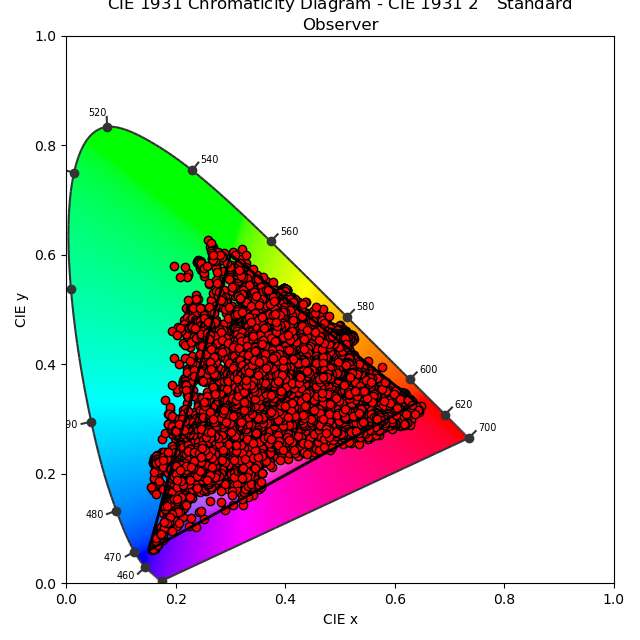

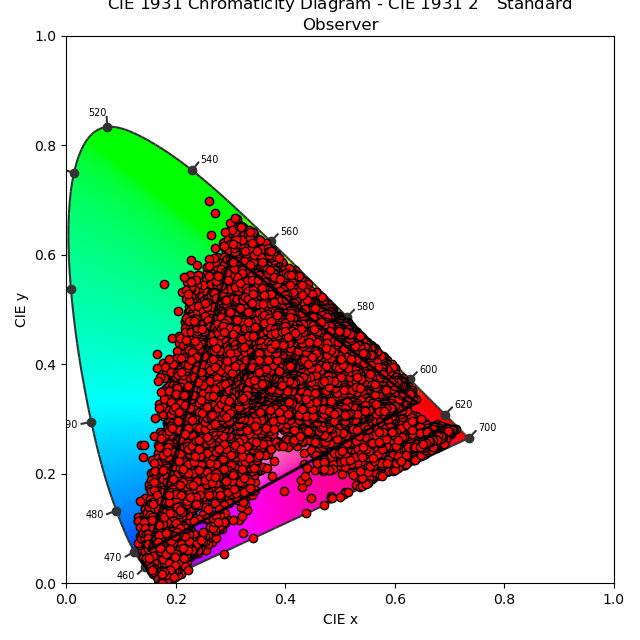

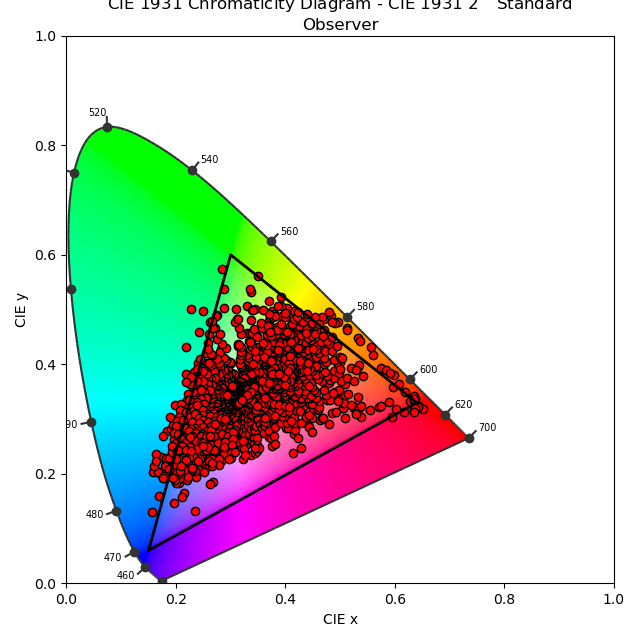

In [99]:
from plotting import plot_chromaticity_diagram
plot_chromaticity_diagram(response_trainset_xyz)
plot_chromaticity_diagram(response_testset_xyz)
plot_chromaticity_diagram(response_validation_xyz)

### Computing Nikon Responses

In [100]:
response_trainset_nikon, _ = colour.characterisation.training_data_sds_to_RGB(TRAIN, MSDS_TRAIN, SDS_TRAIN)
response_testset_nikon, _ = colour.characterisation.training_data_sds_to_RGB(TEST, MSDS_TRAIN, SDS_TRAIN)

### Fit Generalized Additive Model with P-splines

In [101]:
from models import GAMOptimizer
from evaluate import pred
gam = GAMOptimizer(lams=0.1, order=3, n_splines=20)
gam.fit(response_trainset_nikon, response_trainset_xyz)
pred(gam, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.4017667881199213
DeltaE max: 2.4229891825729672
DeltaE min: 0.0033221278705554804
DeltaE median: 0.3387639517455284
DeltaE 95 percentile: 0.9409054755488201
DeltaE 99 percentile: 1.2676755933763144


### Fit Linear Model

In [102]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()


linear.fit(response_trainset_nikon, response_trainset_xyz)
pred(linear, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.5419366923272113
DeltaE max: 3.121133296991245
DeltaE min: 0.004582792988889542
DeltaE median: 0.4646893444087498
DeltaE 95 percentile: 1.1801071459756047
DeltaE 99 percentile: 1.682395758195453


### Fit 3rd order Root-Polynomial Model

In [103]:
from models import GAMOptimizer, PolynomialTransformer, DeltaEOptimizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=True)),
    ('regressor', LinearRegression())
])


RP_linear.fit(response_trainset_nikon, response_trainset_xyz)
pred(RP_linear, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.5030572304656513
DeltaE max: 3.0824982198949273
DeltaE min: 0.005171908724511866
DeltaE median: 0.42363005753745525
DeltaE 95 percentile: 1.1122660714749446
DeltaE 99 percentile: 1.4618358765900654


### Fit a 2nd order Root-Polynomial Model

In [104]:
from models import GAMOptimizer, PolynomialTransformer, DeltaEOptimizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=True)),
    ('regressor', LinearRegression())
])


RP_linear.fit(response_trainset_nikon, response_trainset_xyz)
pred(RP_linear, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.4950867620625434
DeltaE max: 2.902879837555313
DeltaE min: 0.004024009981834654
DeltaE median: 0.4226410108761396
DeltaE 95 percentile: 1.0931123385558725
DeltaE 99 percentile: 1.3756757848428636


In [105]:
P_linear = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=False)),
    ('regressor', LinearRegression())
])


P_linear.fit(response_trainset_nikon, response_trainset_xyz)
pred(P_linear, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.5002748088573402
DeltaE max: 3.106015033197395
DeltaE min: 0.004221965370826995
DeltaE median: 0.4075640277246937
DeltaE 95 percentile: 1.1198187183835002
DeltaE 99 percentile: 1.480169377269381


In [106]:
P_linear = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=False)),
    ('regressor', LinearRegression())
])


P_linear.fit(response_trainset_nikon, response_trainset_xyz)
pred(P_linear, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.53261421214898
DeltaE max: 3.1517664299382107
DeltaE min: 0.007755075347293308
DeltaE median: 0.4418464769161429
DeltaE 95 percentile: 1.1925605794674747
DeltaE 99 percentile: 1.6081356046716133


In [107]:
%%script false --no-raise-error

DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=False, degree=3))
])


DE2000RP.fit(response_trainset_nikon, response_trainset_xyz)
pred(DE2000RP, response_testset_nikon, response_testset_xyz, "DeltaE Foster+CAVE")

Couldn't find program: 'false'


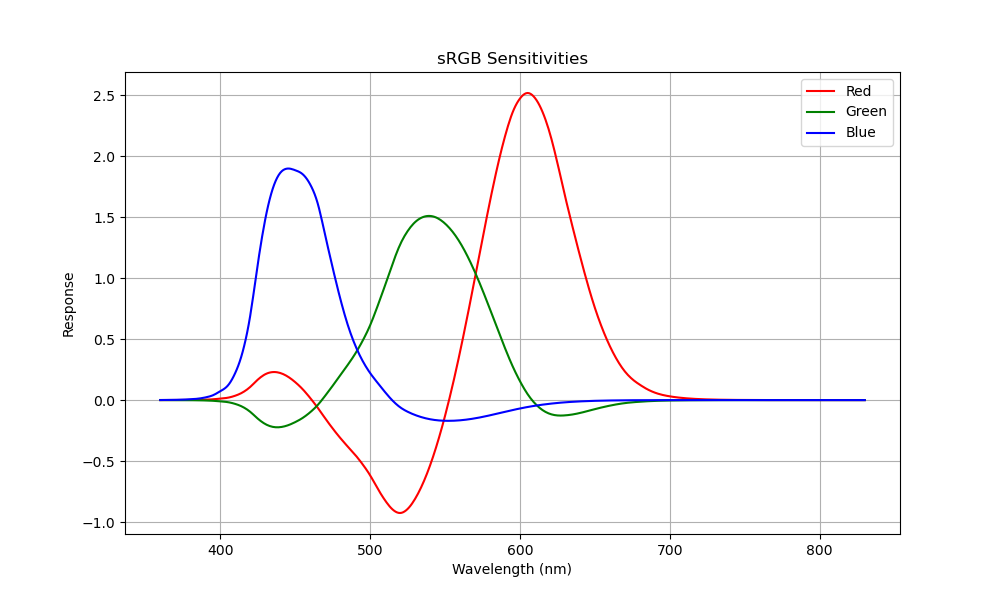

In [108]:
import colour
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the XYZ colour matching functions.
cmfs = colour.colorimetry.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']

# Wavelengths of the standard observer.
wavelengths = cmfs.wavelengths

# Converting XYZ to sRGB sensitivities
# sRGB colour matching functions are derived from the XYZ ones by applying the sRGB colour space matrix.
rgb_colourspace = colour.RGB_COLOURSPACES['sRGB']
matrix_XYZ_to_RGB = rgb_colourspace.matrix_XYZ_to_RGB

# Applying the matrix to each XYZ sensitivity
sRGB_sensitivities = np.dot(cmfs.values, matrix_XYZ_to_RGB.T)

# Plotting the sensitivities
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, sRGB_sensitivities[:, 0], label='Red', color='r')
plt.plot(wavelengths, sRGB_sensitivities[:, 1], label='Green', color='g')
plt.plot(wavelengths, sRGB_sensitivities[:, 2], label='Blue', color='b')
plt.title('sRGB Sensitivities')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.legend()
plt.grid(True)
plt.show()


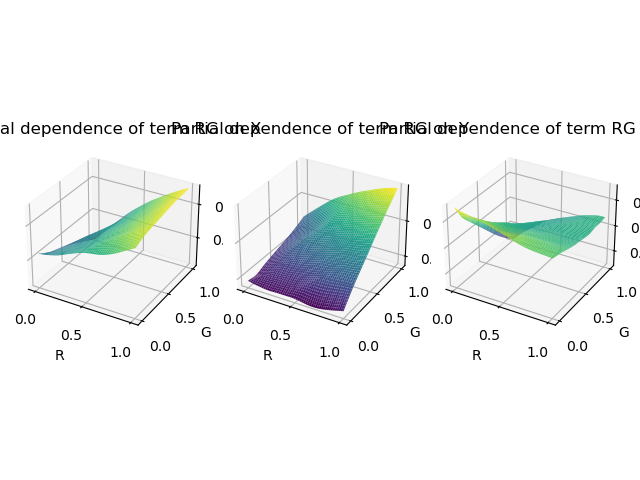

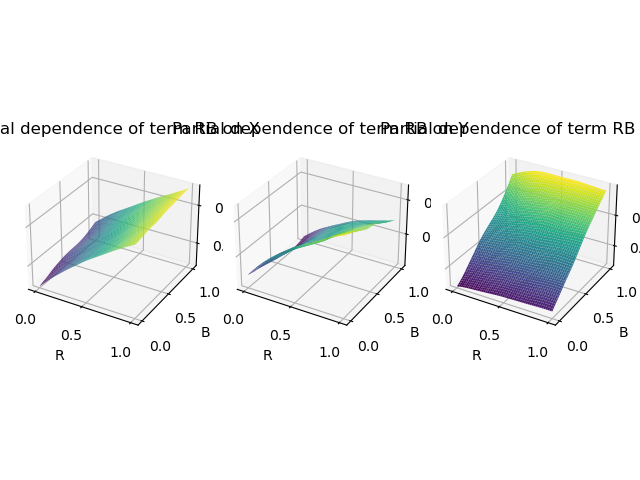

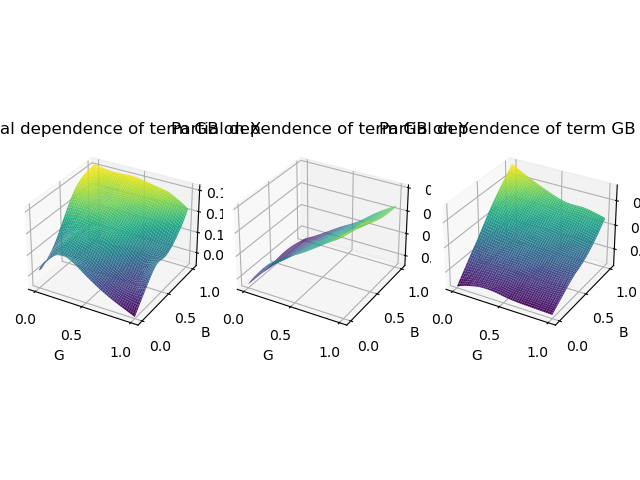

In [114]:
%matplotlib ipympl

gam.plot_partial_dependences()